# Analyzing Star Wars Movie Scripts

With the movie Solo: A Star Wars Story out in theaters, I wanted to do a quick analysis of the Star Wars movie scripts--notably, the original Trilogy Episodes (IV, V, and VI). The files used for the analysis can are avaliable [here](https://github.com/gastonstat/StarWars/tree/master/Text_files). One question we would like to answer is if the rebels have a boarder range of words compared to the Imperials. 

## Load Data

In [1]:
#load libraries 
import glob
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

## Loading and Cleaning the Data
We will load the dataset while removing the whitespaces, punctuations, and any "bad lines." Then we will join the remaining data frames into one. We will split each line into tokens, parse out common stopwords--words that provide no meaning to the analysis--and combine each line.

In [2]:
#read and combine each file - Episode IV, V, VI
files = glob.glob("text/*.txt")
#remove punctuation, whitespace, and drop any errors from the data frame
read_files = [pd.read_table(x, error_bad_lines=False, delim_whitespace=True, header=0, escapechar='\\') for x in files]
#join multiple data frames
starwars = pd.concat(read_files)

In [49]:
starwars.head(10) #check if everything is OK

,character,dialogue
1,LUKE,Echo Three Echo Seven Han old buddy read me
2,HAN,Loud clear kid Whats up
3,LUKE,Well I finished circle I pick life readings
4,HAN,There enough life ice cube fill space cruiser ...
5,LUKE,Right Ill see shortly Theres meteorite hit gro...
6,LUKE,Hey steady girl Whats matter You smell something
7,LUKE,Aaargh
8,HAN,Chewie
9,HAN,All right lose temper Ill come right back give...
10,RIEEKAN,Solo


In [4]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))

In [53]:
#remove stop words
starwars.dialogue = starwars.dialogue.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
#starwars.dialogue = starwars.dialogue.str.replace('[^\w\s]','')

## Analyzing the Data
We will filter characters that have more than 20 lines in the trilogy and plot the results.

In [37]:
#filter characters with more than 20 lines
character_count = starwars.character.value_counts()
filter_characters = character_count[character_count > 20]
#find the percentage of dialogues per character
pct_lines = (filter_characters / starwars.shape[0]) * 100

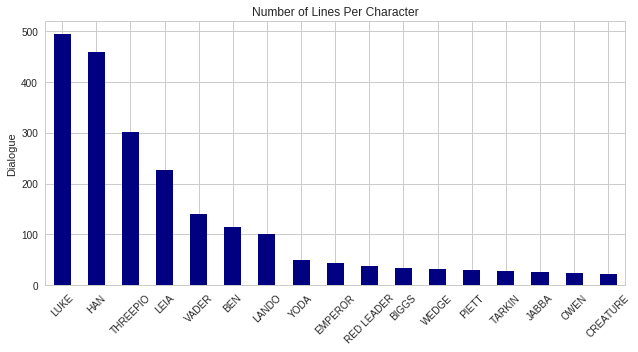

In [38]:
#visualize the results
fix, ax = plt.subplots(figsize=(9,5))
filter_characters.plot(kind="bar", rot=45, title="Number of Lines Per Character", colormap='jet')
ax.set_ylabel("Dialogue")
plt.tight_layout()     

Not surprising, really; the rebels are more lines than the neutral and imperial characters. The top four are Luke, Han, Threepio, and Leia. These four characters have more lines than the rest combined. How does each character fair if we take the percentage of dialogues by character?

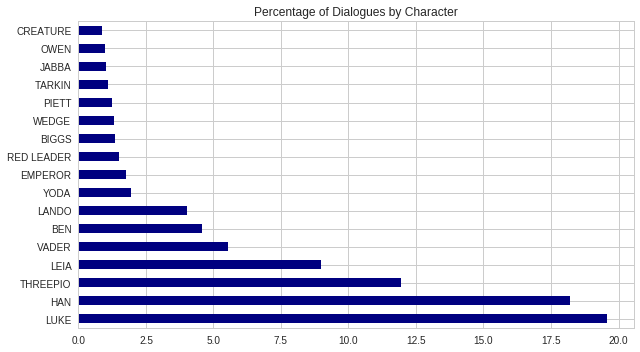

In [41]:
plt.figure(figsize=(9,5))
pct_lines.plot(kind="barh", title="Percentage of Dialogues by Character", colormap='jet')
plt.tight_layout()

Luke, Han, Threepio, and Leia combined for more than half (58.4%) of the lines in the original trilogy. Since the rest of the characters have fewer dialogues than the top 4, their lines may have limited vocabulary. We could be on to something here.  

### Vectorizing Data Using Term Frequency
A great way to extract exciting features in text data is to use the term frequency-inverse document frequency method (TF-IDF). We will use sklearn's `CountVectorizer` and `TfidfTransformer` to count the most relevant words and determine the importance of each word.  Both of these estimators, combined with the pipeline class, will return a bag of words. 

Each sentence within the dialogue column gets represented in a high dimensional space equalling to the length of the vocabulary. To plot the effects of these two estimators have in the dialogue column, we need to reduce the dimensions--that is, transform it into a 2D representation. This is where the Principal Component Analysis (PCA) comes in. PCA lowers the data complexity into a lower dimension to reveal hidden structures that underlie it. 

Let's assign colors to each character to understand the plot points when we visualize the PCA model:

- The main rebels (like Luke, Han, Threepio) are in blue.
- The secondary rebels are in yellow
- Vader and Emperor are in red.
- Yoda is in green.
- The Imperials are in cyan.
- The neutral characters are in black.

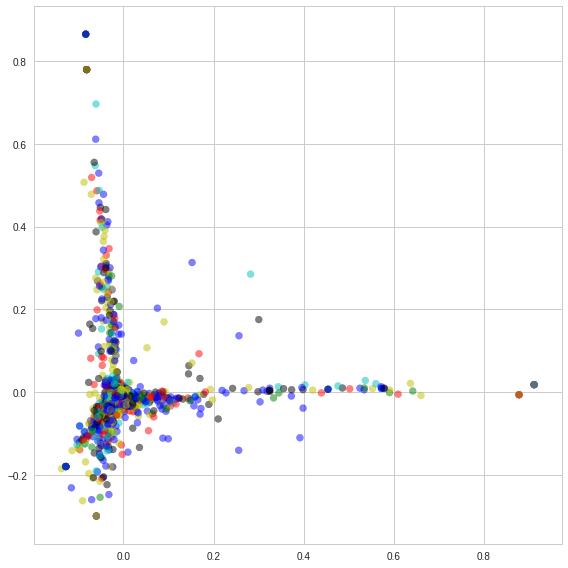

In [47]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

df_copy = starwars.copy()

#filter characters with more than 20 lines
filter_list = ['LUKE', 'HAN', 'THREEPIO', 'LEIA', 'VADER', 'BEN', 'LANDO', 'YODA',
       'EMPEROR', 'RED LEADER', 'BIGGS', 'WEDGE', 'PIETT', 'TARKIN', 'JABBA',
       'OWEN', 'CREATURE']
color_list = ['b', 'b', 'b', 'b', 'r', 'b', 'y', 'g', 'r', 'y', 'y', 'y', 'c', 'c', 'k', 'k', 'k']
df_copy = df_copy[df_copy.character.isin(filter_list)]

#chain multiple estimators into one
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer())
])

#fit and transform model
X = pipeline.fit_transform(df_copy.dialogue).todense()
pca = PCA(n_components=2).fit(X)
reduce2D = pca.transform(X)

#create a new dataframe and reset the index
df = pd.DataFrame(data=reduce2D, index=df_copy.character)
df = df.reset_index()

#visualize pca
plt.figure(figsize=(8,8))
plt.scatter(x=df[0], y=df[1], c=color_list, alpha=0.5)
plt.tight_layout()

## Conclusion
Note the blue and yellow dots: they are mostly scattered over the plane while the red and cyan dots are concentrated in the *line doing down from the left*. All this means is that the rebels have a boarder range of words than the Imperials. Makes sense since the rebels have more lines than the Imperials.